In [1]:
#   Copyright (c) 2018 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import errno
import math
import os

import matplotlib
%matplotlib inline
import numpy
np = numpy

import paddle
import paddle.fluid as fluid

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

NOISE_SIZE = 100
NUM_PASS = 1000
NUM_REAL_IMGS_IN_BATCH = 121
NUM_TRAIN_TIMES_OF_DG = 3
LEARNING_RATE = 2e-4

gf_dim = 64
gfc_dim = 1024*2
dfc_dim = 1024
df_dim = 64
img_dim = 28

def get_parent_function_name():
    import inspect
    return inspect.stack()[2][3] + '.' + inspect.stack()[1][3] + '.' +str(inspect.stack()[2][2]) + '.'

def mybn(x, name=None, act='relu'):
    if name is None:
        name = get_parent_function_name()
    #return fluid.layers.leaky_relu(x)
    return fluid.layers.batch_norm(x, 
          param_attr=name+'1', 
          bias_attr=name+'2', 
          moving_mean_name=name+'3', 
          moving_variance_name=name+'4', name=name,
          act=act)
    
def myconv(x, num_filters, name=None, act=None):
    if name is None:
        name = get_parent_function_name()
    return fluid.nets.simple_img_conv_pool(
        input=x,
        filter_size=5,
        num_filters=num_filters,
        pool_size=2,
        pool_stride=2, param_attr=name+'w', bias_attr=name+'b',
        act=act)

def myfc(x, num_filters, name=None, act=None):
    if name is None:
        name = get_parent_function_name()
    return fluid.layers.fc(input=x, size=num_filters, act=act, param_attr=name+'w', bias_attr=name+'b')
    
def mydeconv(x, num_filters, name=None, filter_size=5, stride=2, dilation=1, padding=2, output_size=None, act=None):
    if name is None:
        name = get_parent_function_name()
    return fluid.layers.conv2d_transpose(input=x, param_attr=name+'w', bias_attr=name+'b',
                            num_filters=num_filters, 
                            output_size = output_size,
                            filter_size=filter_size,
                            stride=stride, 
                            dilation=dilation, 
                            padding=padding,
                            act=act)

def D(x):
    x = fluid.layers.reshape(x=x, shape=[-1, 1, 28, 28])
    x = myconv(x, df_dim, act='leaky_relu')
    x = mybn(myconv(x, df_dim*2), act='leaky_relu')
    x = mybn(myfc(x, dfc_dim), act='leaky_relu')
    x = myfc(x, 1, act=None)
    return x


def G(x):
    x = mybn(myfc(x, gfc_dim))
    x = mybn(myfc(x, gf_dim*2 * img_dim/4 * img_dim/4))
    x = fluid.layers.reshape(x, [-1, gf_dim*2, img_dim/4, img_dim/4])
    #x = mybn(mydeconv(x, gf_dim*2))
    x = mydeconv(x, gf_dim*2, act='relu', output_size=[14,14])
    #x = mybn(mydeconv(x, 1,  padding=2, act=None), act='leaky_relu')
    #x = mydeconv(x, 1,  padding=2, act='leaky_relu') *3
    #x = mydeconv(x, 1,  padding=2, act='tanh')*2
    x = mydeconv(x, 1,  filter_size=5, padding=2, act='tanh', output_size=[28,28])
    #print x
    #x = fluid.layers.slice(x, axes=[2,3], starts=[0,0], ends=[280,280])
    #print x
    #x = fluid.layers.resize_bilinear(x, [28,28])
    x = fluid.layers.reshape(x, shape=[-1, 28*28])
    #print hidden
    #print '-------'
    return x

def plot(gen_data):
    pad_dim = 1
    paded = pad_dim + img_dim
    gen_data = gen_data.reshape(gen_data.shape[0], img_dim, img_dim)
    n = int(math.ceil(math.sqrt(gen_data.shape[0])))
    gen_data = (np.pad(gen_data, [[0, n*n-gen_data.shape[0]], [pad_dim, 0], [pad_dim, 0]], 'constant')
                .reshape((n,n,paded,paded))
                .transpose((0,2,1,3))
                .reshape((n*paded, n*paded))
    )
    fig = plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(gen_data,  cmap='Greys_r', vmin=-1, vmax=1)
    return fig

def check(a):
    a = np.sort(np.array(a).flatten())
    return [np.average(a), np.min(a), np.max(a), 
            a[int(len(a)*0.25)], a[int(len(a)*0.75)] ]

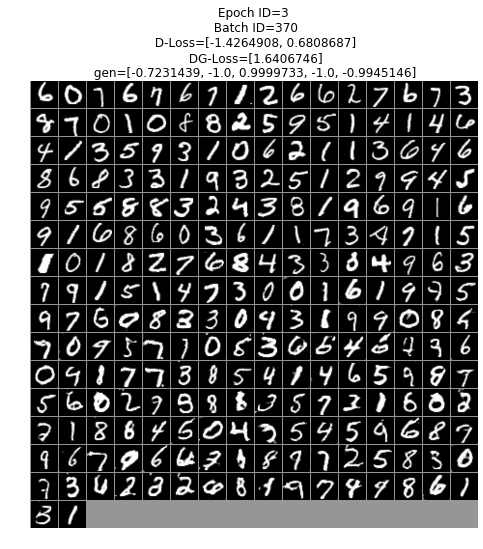

mkdir: cannot create directory ‘backup’: File exists
out_2018年 07月 25日 星期三 11:35:44 CST
out_2018年 07月 25日 星期三 11:38:19 CST
out_2018年 07月 25日 星期三 11:42:31 CST
out_2018年 07月 25日 星期三 11:47:48 CST
out_2018年 07月 25日 星期三 11:51:27 CST
out_2018年 07月 25日 星期三 11:59:01 CST
out_2018年 07月 25日 星期三 12:06:06 CST
out_2018年 07月 25日 星期三 12:32:23 CST
out_2018年 07月 25日 星期三 12:48:09 CST
out_2018年 07月 25日 星期三 13:02:13 CST
out_2018年 07月 25日 星期三 13:13:28 CST
out_2018年 07月 25日 星期三 13:38:28 CST
out_2018年 07月 25日 星期三 14:00:13 CST
out_2018年 07月 25日 星期三 14:54:19 CST
out_2018年 07月 25日 星期三 15:09:02 CST
out_2018年 07月 25日 星期三 15:09:32 CST
out_2018年 07月 25日 星期三 15:21:04 CST
out_2018年 07月 25日 星期三 16:32:49 CST
out_2018年 07月 25日 星期三 16:35:55 CST
out_2018年 07月 25日 星期三 16:37:37 CST
out_2018年 07月 25日 星期三 16:39:57 CST
out_2018年 07月 25日 星期三 16:47:30 CST
out_2018年 07月 25日 星期三 16:52:17 CST
out_2018年 07月 25日 星期三 16:54:36 CST
['G.mybn.96.4', 'G.mydeconv.103.w', 'G.mybn.96.2', 'G.mydeconv.99.w', 'G.myfc.96.b', 'G.mybn.95.1', 'G.mybn

KeyboardInterrupt: 

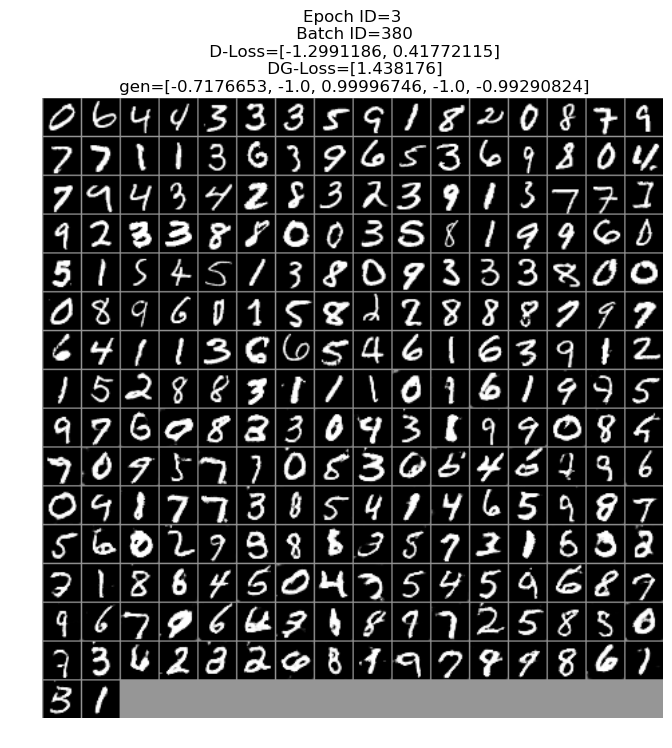

In [4]:

from IPython import display
handle = display.DisplayHandle()
handle.display('wait')

ff = !ls out
if len(ff):
    !mkdir backup
    !mv out backup/out_"$(date)"
    !ls backup

try:
    os.makedirs("./out")
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

startup_program = fluid.Program()
d_program = fluid.Program()
dg_program = fluid.Program()

def myloss(x, label):
    #return fluid.layers.sigmoid_cross_entropy_with_logits(x=x, label=label)
    return x*(label-0.5)

with fluid.program_guard(d_program, startup_program):
    img = fluid.layers.data(name='img', shape=[784], dtype='float32')
    d_logit = D(img)
    d_loss = myloss(
        x=d_logit,
        label=fluid.layers.data(
            name='label', shape=[1], dtype='float32'))
    d_loss = fluid.layers.mean(d_loss)

with fluid.program_guard(dg_program, startup_program):
    noise = fluid.layers.data(
        name='noise', shape=[NOISE_SIZE], dtype='float32')
    g_img = G(x=noise)
    g_program = dg_program.clone()
    g_program_test = dg_program.clone(for_test=True)
    dg_logit = D(g_img)
    dg_loss = myloss(
        x=dg_logit,
        label=fluid.layers.fill_constant_batch_size_like(
            input=noise, dtype='float32', shape=[-1, 1], value=1.0))
    dg_loss = fluid.layers.mean(dg_loss)

opt = fluid.optimizer.Adam(learning_rate=LEARNING_RATE)

#opt = fluid.optimizer.Momentum(learning_rate=LEARNING_RATE, momentum=0.9)

opt.minimize(loss=d_loss, startup_program=startup_program)
parameter_list =[
        p.name for p in g_program.global_block().all_parameters()
    ]

opt.minimize(
    loss=dg_loss,
    startup_program=startup_program,
    parameter_list=parameter_list)
print parameter_list
print [
        p.name for p in startup_program.global_block().all_parameters()
    ]

exe = fluid.Executor(fluid.CUDAPlace(1))
#exe = fluid.Executor(fluid.CPUPlace())
exe.run(startup_program)

num_true = NUM_REAL_IMGS_IN_BATCH
train_reader = paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.mnist.train(), buf_size=60000),
    batch_size=num_true)

NUM_TRAIN_TIMES_OF_DG = 2
const_n = numpy.random.uniform(
    low=-1.0, high=1.0,
    size=[num_true * NOISE_SIZE]).astype('float32').reshape(
        [num_true, NOISE_SIZE])
img_id = 0
for pass_id in range(5):#NUM_PASS):
    for batch_id, data in enumerate(train_reader()):
        num_true = len(data)
        n = numpy.random.uniform(
            low=-1.0, high=1.0,
            size=[num_true * NOISE_SIZE]).astype('float32').reshape(
                [num_true, NOISE_SIZE])
        generated_img = exe.run(g_program,
                                feed={'noise': n},
                                fetch_list={g_img})[0]
        real_data = numpy.array(map(lambda x: x[0], data)).astype('float32')
        real_data = real_data.reshape(num_true, 784)
        total_data = numpy.concatenate([real_data, generated_img])
        total_label = numpy.concatenate([
            numpy.ones(
                shape=[real_data.shape[0], 1], dtype='float32'),
            numpy.zeros(
                shape=[real_data.shape[0], 1], dtype='float32')
        ])
        d_loss_np = [exe.run(d_program,
                            feed={'img': total_data[num_true:],
                                  'label': total_label[num_true:]},
                            fetch_list={d_loss})[0][0]
                     ,
                     exe.run(d_program,
                            feed={'img': total_data[:num_true],
                                  'label': total_label[:num_true]},
                            fetch_list={d_loss})[0][0]]
        for _ in xrange(NUM_TRAIN_TIMES_OF_DG):
            n = numpy.random.uniform(
                low=-1.0, high=1.0,
                size=[2 * num_true * NOISE_SIZE]).astype('float32').reshape(
                    [2 * num_true, NOISE_SIZE, 1, 1])
            dg_loss_np = exe.run(dg_program,
                                 feed={'noise': n},
                                 fetch_list={dg_loss})[0]
        if batch_id % 10 == 0:
            # generate image each batch
            generated_img = exe.run(g_program_test,
                                    feed={'noise': const_n},
                                    fetch_list={g_img})[0]
            total_data = numpy.concatenate([real_data, generated_img])
            fig = plot(total_data)
            msg = "Epoch ID={0}\n Batch ID={1}\n D-Loss={2}\n DG-Loss={3}\n gen={4}".format(
                pass_id, batch_id, d_loss_np, dg_loss_np, check(generated_img))
            plt.title(msg)
            plt.savefig(
                'out/{:04d}.png'.format(img_id), bbox_inches='tight')
            img_id += 1
            handle.update(fig)
            plt.close(fig)